# Generating Image Descriptions using Amazon Rekognition and Amazon Bedrock

## Using computer vision (Amazon Rekognition) to extract labels/concepts from images, and then leveraging Amazon Bedrock large language models to convert those labels into descriptive captions or paragraphs.

In [31]:
!pip install scikit-image
!pip install ipywidgets
!pip install langchain
!pip install gtts
!pip install langchain
!pip install -U boto3
!pip install botocore
!pip install matplotlib


[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 1.4 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 38.3 MB/s eta 0:00:0000:010:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.31.62
    Uninstalling botocore-1.31.62:
      Successfully uninstalled botocore-1.31.62
  Attempting uninstall: boto3
    Found existing installation: boto3 1.28.62
    Uninstalling boto3-1.28.62:

In [32]:
#list of imports

import boto3
import json
from langchain import PromptTemplate
from gtts import gTTS
import os
from IPython.display import display
import ipywidgets as widgets
from skimage import io

In [33]:
pip show boto3

Name: boto3
Version: 1.28.63
Summary: The AWS SDK for Python
Home-page: https://github.com/boto/boto3
Author: Amazon Web Services
Author-email: 
License: Apache License 2.0
Location: /usr/local/lib/python3.10/site-packages
Requires: botocore, jmespath, s3transfer
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [34]:
pip show botocore

Name: botocore
Version: 1.31.63
Summary: Low-level, data-driven core of boto 3.
Home-page: https://github.com/boto/botocore
Author: Amazon Web Services
Author-email: 
License: Apache License 2.0
Location: /usr/local/lib/python3.10/site-packages
Requires: jmespath, python-dateutil, urllib3
Required-by: awscli, boto3, s3transfer
Note: you may need to restart the kernel to use updated packages.


In [35]:
#initialize bedrock client for given region and endpoint. Change as per your region

#bedrock_client = boto3.client('bedrock-runtime' , 'us-west-2')

bedrock_client = boto3.client(
    service_name='bedrock-runtime', 
    region_name='us-west-2'
)

In [36]:
#select the LLM type from Amazon Bedrock. The 'interactWithLLM' function handles the given LLM type calling based on the type passed
#llm type can be 'claude' or 'titan' for this notebook. 

llm_type = 'claude'

In [37]:
#prompt for claude

prompt_claude = """
Human:  Here are the comma seperated list of labels/objects seen in the image:
<labels>
{labels}
</labels>
Please provide a human readible and Understandable summary based on these labels
Assistant:
"""

In [38]:
# Interact with a large language model (LLM) to generate text 
# based on a prompt.
#
# Arguments:
#   prompt: The text prompt to provide to the LLM.
#   llm_type: The name of the LLM to use, either 'titan' or 'claude'. 
#
# Returns:
#   The text generated by the LLM in response to the prompt.
#   
# This function:
# 1. Prints the llm_type for debugging.
# 2. Formats the prompt into the JSON payload expected by each LLM API.
# 3. Specifies the parameters for text generation like max tokens, temp.
# 4. Calls the Bedrock client to invoke the LLM model API. 
# 5. Parses the response to extract the generated text.
# 6. Returns the generated text string.

def interactWithLLM(prompt,llm_type):

	if llm_type == 'titan':
		print("**THE LLM TYPE IS -->" + llm_type)
		#Test for invoke model begins
		parameters = {
			"maxTokenCount":512,
			"stopSequences":[],
			"temperature":0,
			"topP":0.9
		}
		body = json.dumps({"inputText": prompt, "textGenerationConfig": parameters})
		modelId = "amazon.titan-tg1-large" #"amazon.titan-tg1-large"
		accept = "application/json"
		contentType = "application/json"

		response = bedrock_client.invoke_model(
			body=body, modelId=modelId, accept=accept, contentType=contentType
		)

		response_body = json.loads(response.get("body").read())

		response_text_titan = response_body.get("results")[0].get("outputText")

		return response_text_titan
	
	elif llm_type == 'claude':
		print("**THE LLM TYPE IS -->" + llm_type)
		body = json.dumps({"prompt": prompt,
                 "max_tokens_to_sample":300,
                 "temperature":1,
                 "top_k":250,
                 "top_p":0.999,
                 "stop_sequences":[]
                  }) 
		modelId = 'anthropic.claude-v2' # change this to use a different version from the model provider
		accept = 'application/json'
		contentType = 'application/json'

		response = bedrock_client.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
		response_body = json.loads(response.get('body').read())

		response_text_claud = response_body.get('completion')

		return response_text_claud

In [39]:
# Analyze an image to detect labels using Amazon Rekognition
#
# Arguments:
#   input_img: File path of image to analyze 
#
# Returns: 
#   label_names: Comma separated string of detected label names
#
# This function:
# 1. Creates a Rekognition client 
# 2. Opens the image file and sends it to Rekognition
# 3. Gets the detected labels and confidence scores
# 4. Filters labels over 85% confidence 
# 5. Prints names and confidences
# 6. Builds string containing detected label names
# 7. Returns label_names string

def imageAnalyzer(input_img):
    
    rek_client = boto3.client('rekognition')

    print(input_img)
    with open(input_img, 'rb') as image:
        response = rek_client.detect_labels(Image={'Bytes': image.read()})

    labels = response['Labels']
    print(f'Found {len(labels)} labels in the image:')
    label_names = ''
    for label in labels:
        name = label['Name']
        confidence = label['Confidence']
        #print(f'> Label "{name}" with confidence {confidence:.2f}')
        if confidence>85:
            print(name + "|" + str(confidence))
            label_names = label_names + name + ","

    return label_names

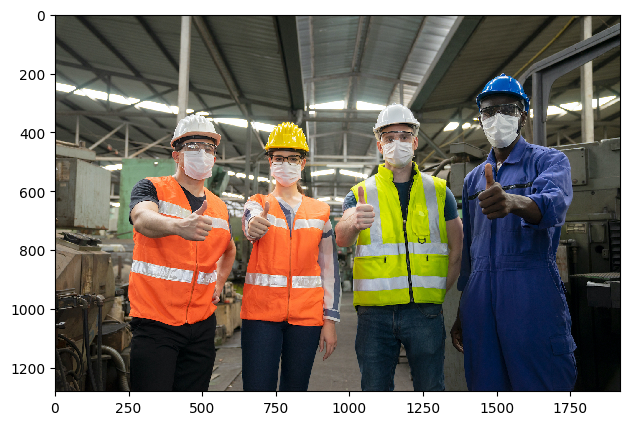

In [40]:
input_img = 'ppe_group_updated.jpg'
img = io.imread(input_img)
io.imshow(img)

In [41]:
label_names = imageAnalyzer(input_img)

ppe_group_updated.jpg
Found 13 labels in the image:
Person|100.0
Worker|100.0
Clothing|99.99998474121094
Hardhat|99.99998474121094
Helmet|99.99998474121094
Adult|98.31719207763672
Male|98.31719207763672
Man|98.31719207763672
Female|96.7901382446289
Woman|96.7901382446289


In [42]:
# Format prompt template with detected labels 
# Pass formatted prompt to LLM to generate summary
#
# Create PromptTemplate from base prompt
# Fill template with label_names to customize prompt
# Print formatted prompt
# Call interactWithLLM() to generate summary text
# Print and return text response

prompt_template_for_summary_generate = PromptTemplate.from_template(prompt_claude)
prompt_data_for_summary_generate = prompt_template_for_summary_generate.format(labels=label_names)
print("prompt_data_for_summary_generate : ->" + prompt_data_for_summary_generate)

response_text = interactWithLLM(prompt_data_for_summary_generate,llm_type)
print('response_text --- \n' + response_text)

prompt_data_for_summary_generate : ->
Human:  Here are the comma seperated list of labels/objects seen in the image:
<labels>
Person,Worker,Clothing,Hardhat,Helmet,Adult,Male,Man,Female,Woman,
</labels>
Please provide a human readible and Understandable summary based on these labels
Assistant:

**THE LLM TYPE IS -->claude
response_text --- 
 Here is a human readable summary based on the provided labels:

The image contains adult men and women wearing protective hardhats and helmets. The people appear to be workers wearing work clothing. There are both male and female adults present.


In [43]:
# Use gTTS to generate audio file from response text

# Create gTTS object with text, language, speed

# Save audio to imageDescription.wav

myobj = gTTS(text=response_text, lang='en', slow=False) 
myobj.save("imageDescription.wav") 